# The GAM Family of Explainable Models



## Contents  

1. [Colab and Environment Preliminaries](#colab-and-environment-preliminaries)
2. [Importing and Preparing Data](#importing-and-preparing-Data)
3. [Elastic Net Penalized GLM w/ Alpha and Lambda Search](#elastic-net)
4. [Generalized Additive Model](#gam)
5. [GA2M and Explainable Boosting Machines](#ebm)
     

## <a name="colab-and-environment-preliminaries"></a> 1. Colab and Environment  Preliminaries



#### Mount shared drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# may need to be updated to location on your drive
%cd drive/My\ Drive/GWU_RML/Lecture_01/
%ls

Mounted at /content/drive/
/content/drive/My Drive/GWU_RML/Lecture_01
01_Explainable_AI_Models.ipynb  Key_of_quiz_01.gdoc  Quiz_01.gdoc


#### Install packages

In [2]:
!pip install h2o interpret pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 71.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778

#### Imports and configs

In [3]:
# Data manipulation, plotting and metrics
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import metrics

# For partial dependence plots
import sys
sys.path.append('..')
from hrml_book import explain

# h2o python bindings to java server
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(max_mem_size='8G', nthreads=4)
h2o.remove_all()
h2o.no_progress()

# PyGAM
from pygam import LogisticGAM

# EBM
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.blackbox import PartialDependence
from interpret import show
from interpret.perf import ROC

# Disable warnings
import warnings
warnings.simplefilter("ignore")
pd.set_option('mode.chained_assignment', None)

SEED = 12345 # set seed for better reproducibility
np.random.seed(SEED)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmd03u3wx
  JVM stdout: /tmp/tmpmd03u3wx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmd03u3wx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 15 days
H2O_cluster_name:,H2O_from_python_unknownUser_8osmex
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## <a name="importing-and-preparing-Data"></a>2. Importing and Preparing Data



In [4]:
data = pd.read_csv('../Data/credit_line_increase.csv')
data.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
0,1,20000,2,1.0,2,1,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,2,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,3.0,2,2,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,4.0,2,1,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,3.0,2,1,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Split data into training and validation sets
Split the data in the training and validation set using a 70:30 ratio.

In [5]:
split_ratio = 0.7 # 70%/30% train/test split

split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

print(f'Shape of Train data : {train.shape}')
print(f'Shape of Validation data : {valid.shape}')

Shape of Train data : (20946, 26)
Shape of Validation data : (9054, 26)


#### Assign target and inputs for models

Note that **demographic** features are not used as model inputs.

In [6]:
target = 'DELINQ_NEXT'
demographic_cols = ['SEX', 'RACE','EDUCATION', 'MARRIAGE', 'AGE']
features = [col for col in data.columns if col not in demographic_cols + ['ID',target]]

print('target =', target)
print('predictors =', features)

target = DELINQ_NEXT
predictors = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


## <a name="elastic-net"></a>3. Elastic Net Penalized GLM with Alpha and Lambda Search



#### Finding the best GLM model using grid search



In [7]:
def glm_grid(x, y, training_frame, validation_frame, seed_, weight=None):

    """
    :param x: List of inputs.
    :param y: Name of target variable.
    :param training_frame: Training H2OFrame.
    :param validation_frame: Validation H2OFrame.
    :param seed_: Random seed for better reproducibility.
    :param weight: A column for weighing observations.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    # Settings GLM grid parameters
    alpha_opts = [0.01, 0.25, 0.5, 0.99]
    hyper_parameters = {'alpha': alpha_opts}

    # initialize cartesian grid search
    glm_grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family="binomial",
                                      lambda_search=True,
                                      seed=seed_),
                                      hyper_params=hyper_parameters)

    # training w/ grid search
    glm_grid.train(y=y,
               x=x,
               training_frame=training_frame,
               validation_frame=validation_frame,
               weights_column=weight,
               seed=seed_)

    # select best model from grid search
    best_model = glm_grid.get_grid()[0]
    del glm_grid

    return best_model

#### Print coefficients

In [8]:
best_glm = glm_grid(x=features, y=target, training_frame=h2o.H2OFrame(train),
                         validation_frame=h2o.H2OFrame(valid), seed_=SEED)

print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Best penalized GLM coefficients:
Intercept:                -1.055305588551922
PAY_AMT1:                 -1.2872717205682538e-05
PAY_AMT2:                 -7.677315940570004e-06
PAY_AMT4:                 -3.6034380665613523e-06
PAY_AMT5:                 -3.1157254010047546e-06
PAY_AMT3:                 -2.5876219146447798e-06
BILL_AMT1:                -2.239155613569082e-06
PAY_AMT6:                 -1.3995508826227209e-06
LIMIT_BAL:                -4.318698429000953e-07
BILL_AMT4:                -1.947884002188358e-07
BILL_AMT2:                -5.687898638929391e-08
BILL_AMT3:                1.0999358759356074e-08
BILL_AMT6:                3.6975484836055143e-07
BILL_AMT5:                8.691341760858e-07
PAY_6:                    0.012282515281904433
PAY_4:                    0.025486634303389932
PAY_5:                    0.046139370544827474
PAY_3:                    0.07909158701433536
PAY_2:                    0.08471364623597703
PAY_0:                    0.5371954715199952


#### Display best GLM information

In [9]:
best_glm

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: Grid_GLM_Key_Frame__upload_b5d34894668757c6580c1887d2554222.hex_model_python_1742218082584_1_model_1


GLM Model: summary
    family    link    regularization                                  lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ----------------------------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    binomial  logit   Elastic Net (alpha = 0.01, lambda = 0.005908 )  nlambda = 100, lambda.max = 13.333, lambda.min = 0.005908, lambda.1se = -1.0  19                            19                             109                     Key_Frame__upload_b5d34894668757c6580c1887d2554222.hex

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.14649158915954702
RMSE: 0.382742196732405
LogLoss: 0.46858126360026076
AUC: 0.7182752479663853
AUCPR: 0.5017943091688167
Gini: 0.4365504959327706
Null degrees of freedom: 20945
Residual degrees of freedom: 20926
Null deviance: 22178.75361964548
Residual deviance: 19629.806294742124
AIC: 19669.806294742124

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24983106738243765
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      13778  2518  0.1545   (2518.0/16296.0)
1      2168   2482  0.4662   (2168.0/4650.0)
Total  15946  5000  0.2237   (4686.0/20946.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.249831     0.514404  205
max f2                       0.0546537    0.594059  377
max f0point5                 0.399178     0.567555  137
max accuracy                 0.418922     0.817053  128
max precision                0.706802     0.797414  34
max recall                   0.00128103   1         399
max specificity              0.989212     0.99957   0
max absolute_mcc             0.399178     0.396395  137
max min_per_class_accuracy   0.221641     0.658925  237
max mean_per_class_accuracy  0.245211     0.690483  210
max tns                      0.989212     16289     0
max fns                      0.989212     4643      0
max fps                      0.00128103   16296     399
max tps                      0.00128103   4650      399
max tnr                      0.989212     0.99957   0
max fnr                      0.989212     0.998495  0
max fpr                      0.00128103   1         399
max tpr                      0.00128103   1         399

Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.20 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100258                   0.719294           3.53926   3.53926            0.785714         0.816889   0.785714                    0.816889            0.0354839       0.0354839                  253.926   253.926            0.0327225
2        0.0200038                   0.610955           2.95272   3.24669            0.655502         0.659815   0.720764                    0.73854             0.0294624       0.0649462                  195.272   224.669            0.0577666
3        0.0300296                   0.590467          

#### Plotting penalized GLM variable importance

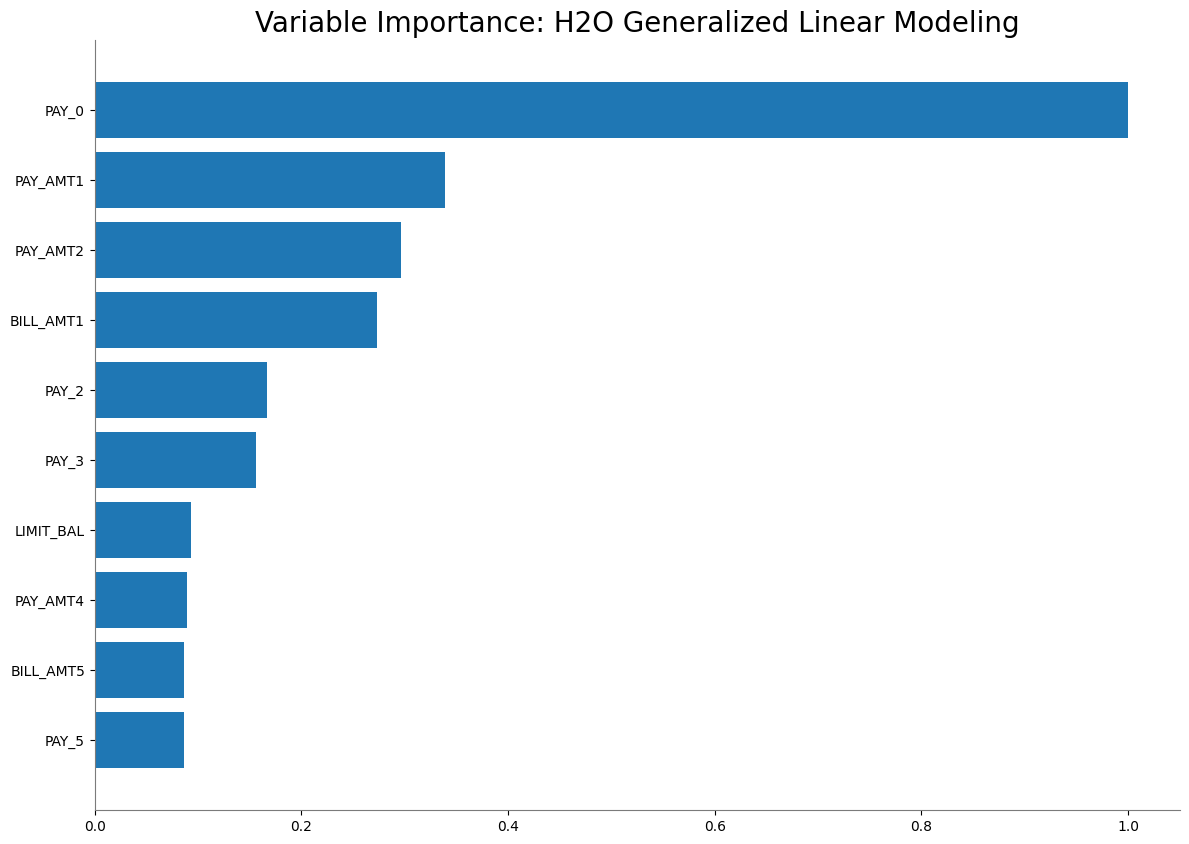

<Figure size 640x480 with 0 Axes>

In [10]:
_ = best_glm.varimp_plot()

#### Computing validation AUC

In [11]:
print("Validation AUC: {0:.4f}".format(best_glm.auc(valid = True)))

Validation AUC: 0.7303


#### Regularization paths in best GLM

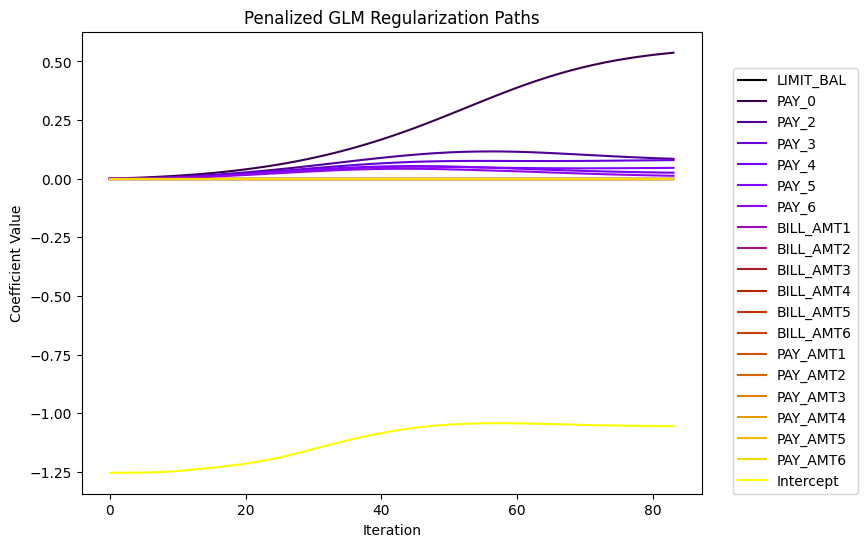

In [12]:
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])):
    reg_path_frame = pd.concat([reg_path_frame, pd.DataFrame(reg_path_dict['coefficients'][i], index=[i])], axis=0)


# plot regularization paths
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame.plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                        colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3,
               borderaxespad=0.)

#### Plotting the partial dependence and ICE plots for selected features in best GLM

In [13]:
glm_predict = lambda data: best_glm.predict(h2o.H2OFrame(data))['p1'].as_data_frame()

pd_ice_dict = {}

# calculate partial dependence for each selected feature
for feat in features:
    pd_ice_dict[feat] = explain.pd_ice_new(feat, valid[features], glm_predict)

In [14]:
def get_percentile_dict(yhat_name, valid, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
    :param yhat_name: Name of column in valid in which to find percentiles.
    :param valid: Pandas validation frame.
    :param id_: Validation Pandas frame containing yhat and id_.
    :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = valid.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict


In [15]:
glm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                            best_glm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                           axis=1)

# rename yhat column
glm_yhat_valid = glm_yhat_valid.rename(columns={'p1':'p_DELINQ_NEXT'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DELINQ_NEXT', glm_yhat_valid, 'ID')

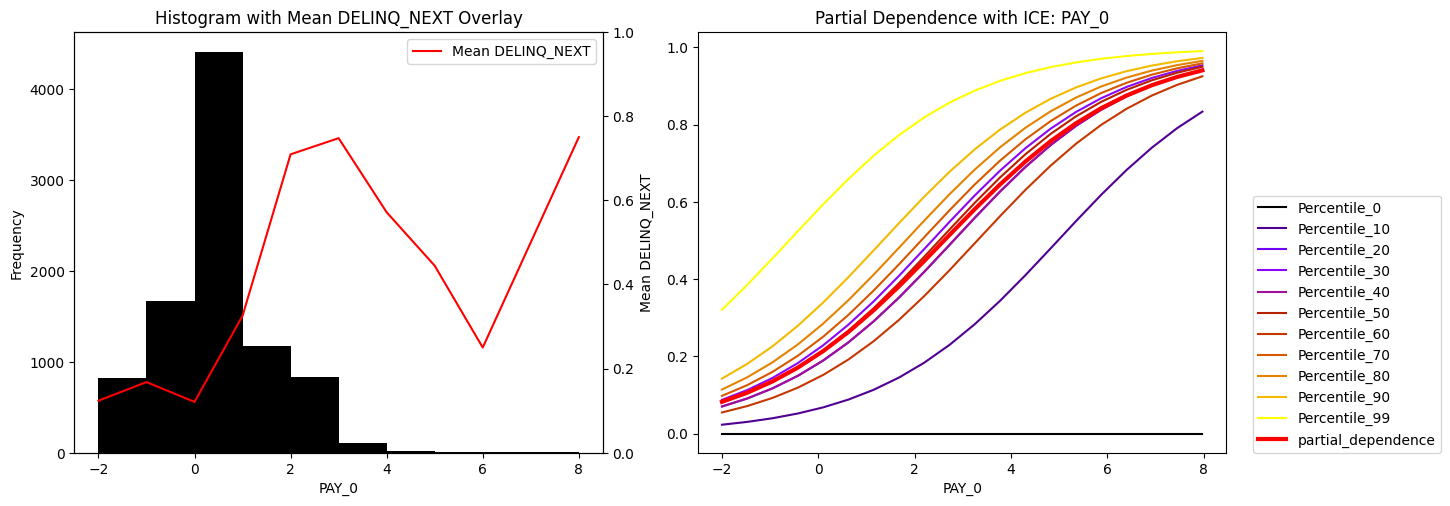

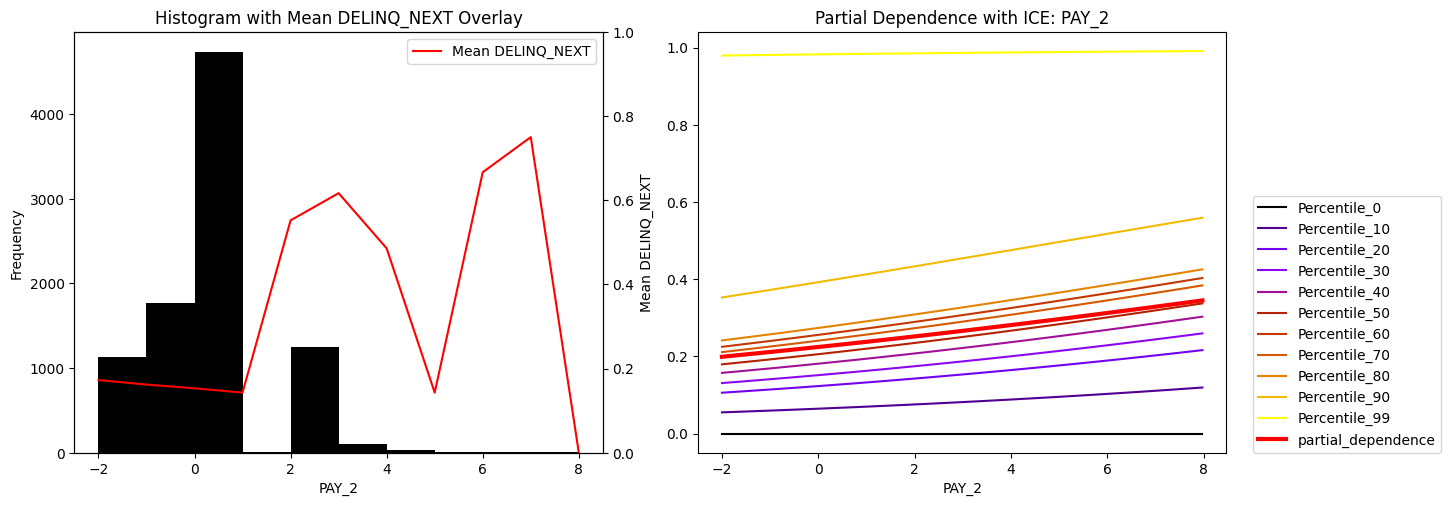

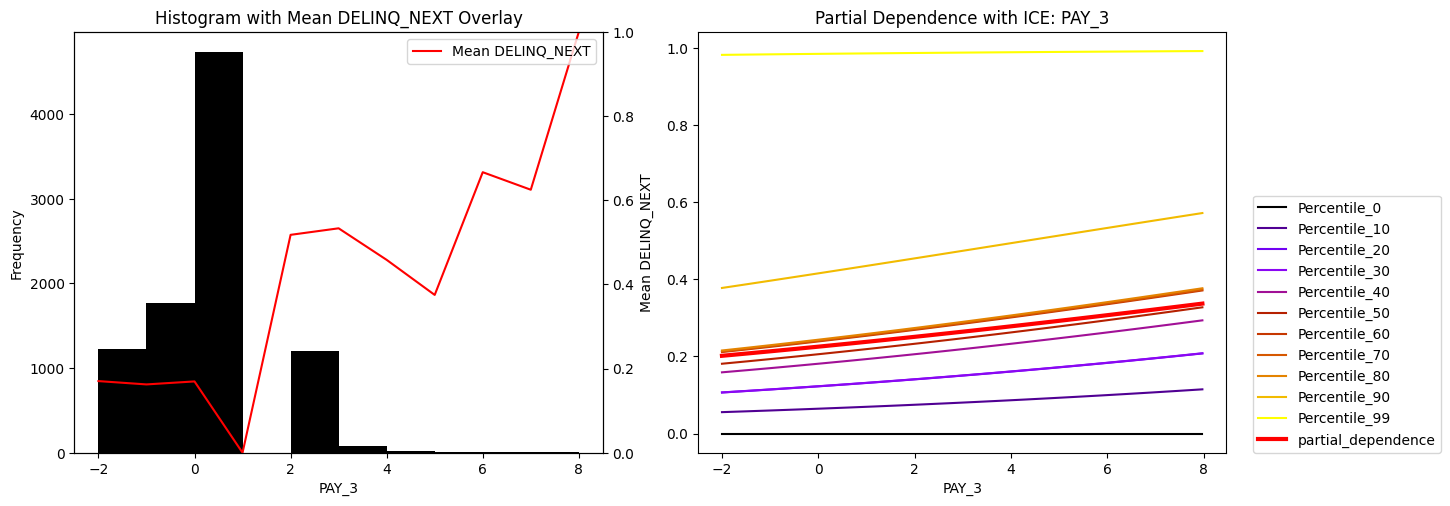

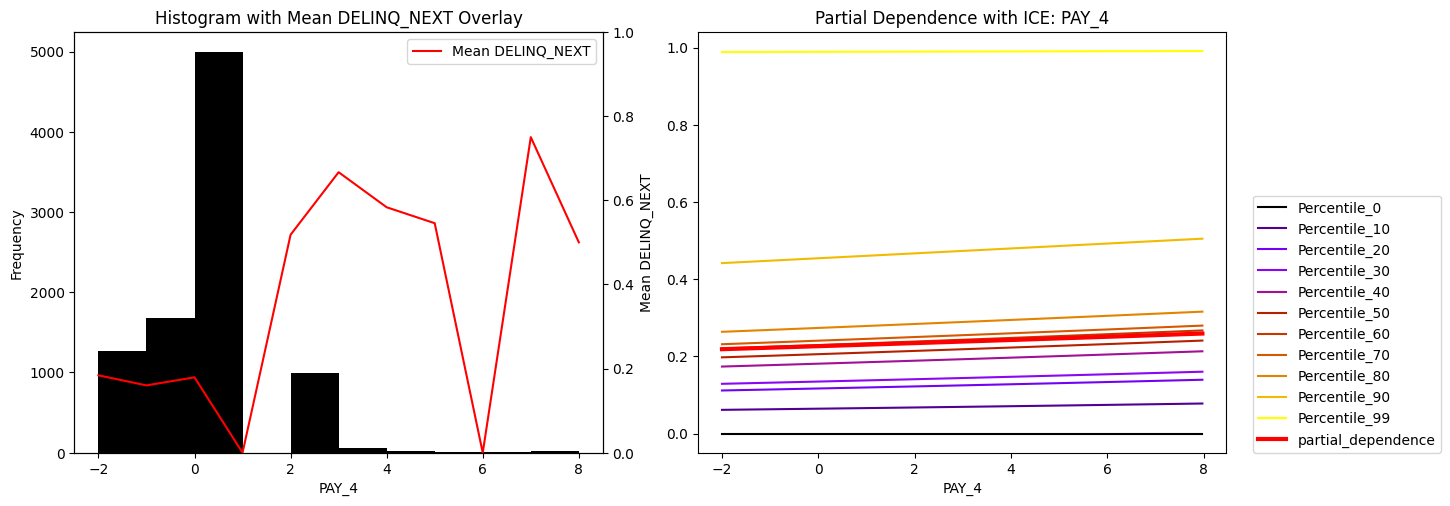

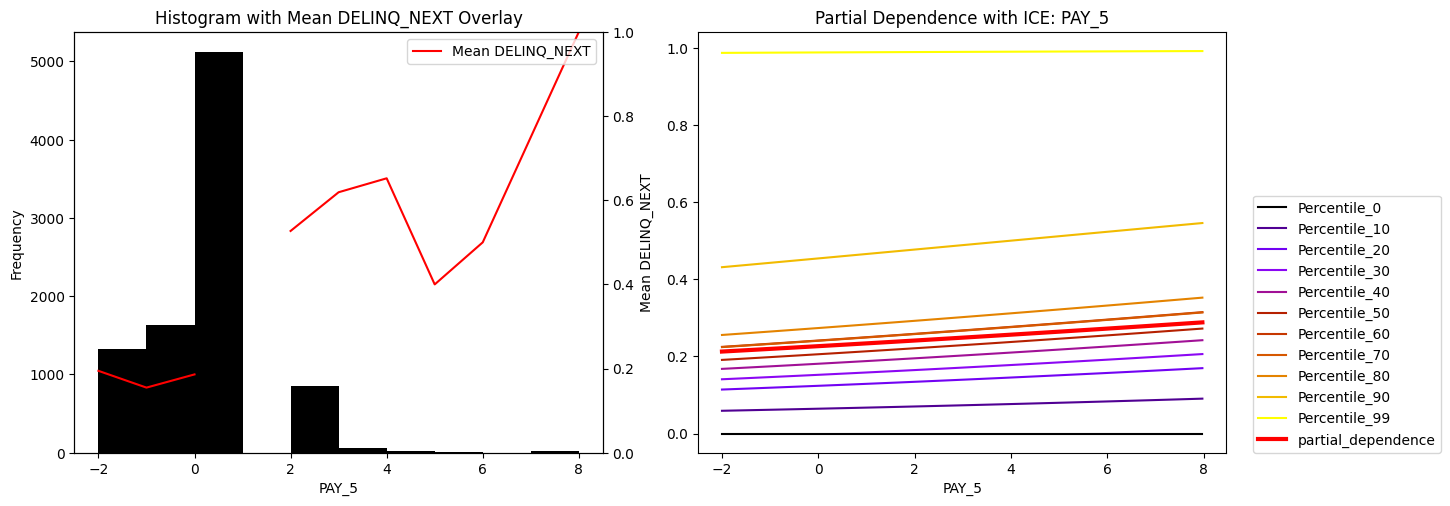

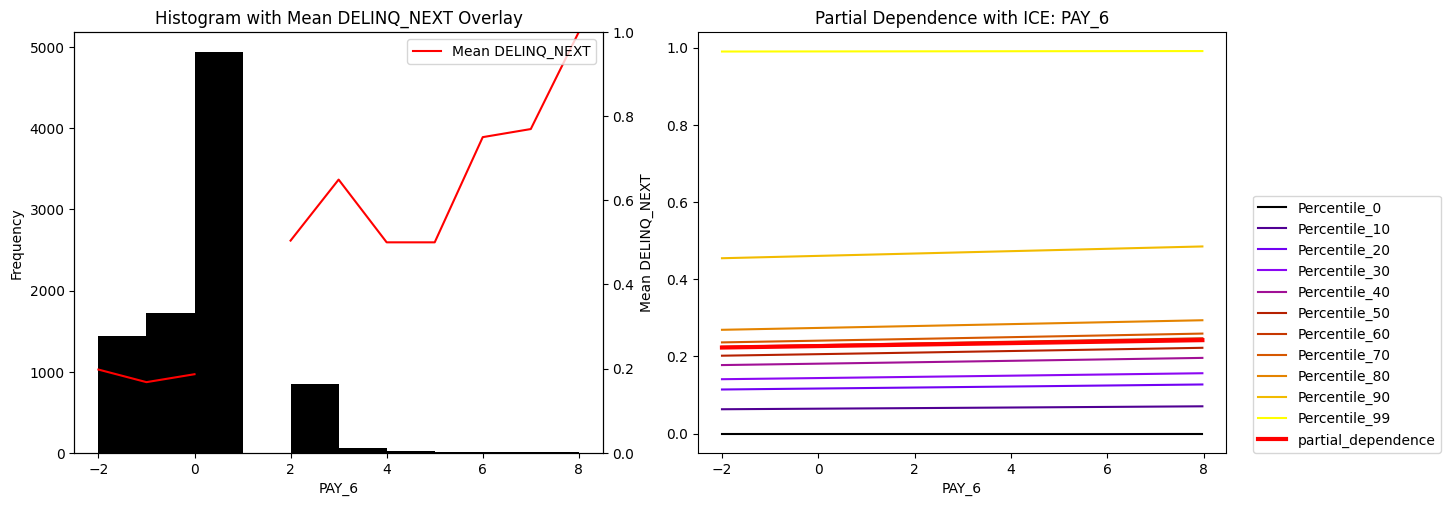

In [16]:
# for brevity, examine most important features

glm_selected = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# loop through selected variables
for feat in glm_selected:

    # collect bins used in partial dependence
    bins = list(pd_ice_dict[feat][feat])

    # calculate ICE at percentiles using partial dependence bins for each feature
    for i in sorted(percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        pd_ice_dict[feat][col_name] = explain.pd_ice_new(feat,
                                                         valid[valid['ID'] == int(percentile_dict[i])],
                                                         glm_predict,
                                                         bins=bins)['partial_dependence']


for feature in glm_selected:
    explain.hist_mean_pd_ice_plot(feature,
                                  target,
                                  valid,
                                  pd_ice_dict)

---

## <a name="gam"></a>4. Generalized Additive Models (GAM)

#### Train Logistic GAM with pyGAM package



In this section we'll  implement a `LogisticGAM` using the [pyGAM](https://github.com/dswah/pyGAM) package in Python. pyGAM's `LogisticGAM` class is used for classification tasks.

In [17]:
from pygam import LogisticGAM

gam = LogisticGAM(max_iter=100, n_splines=30)

#### Finding the best LogisticGAM model using Grid Search

In [18]:
gam.gridsearch(train[features].values, train[target], lam=np.logspace(-3, 3, 15))

100% (15 of 15) |########################| Elapsed Time: 0:06:14 Time:  0:06:14


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + intercept,
   tol=0.0001, verbose=False)

#### Display tuned GAM information


In [19]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     83.7605
Link Function:                        LogitLink Log Likelihood:                                 -9074.1214
Number of Samples:                        20946 AIC:                                            18315.7639
                                                AICc:                                           18316.4608
                                                UBRE:                                               2.8776
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1817
Feature Function                  Lam

### Computing validation AUC

In [20]:
predictions = gam.predict_proba(valid[features])
validation_auc = metrics.roc_auc_score(valid[target], predictions)
print("Validation AUC: {0:.4f}".format(validation_auc))

Validation AUC: 0.7799


### Plotting the Partial Dependence and ICE plots for best GAM

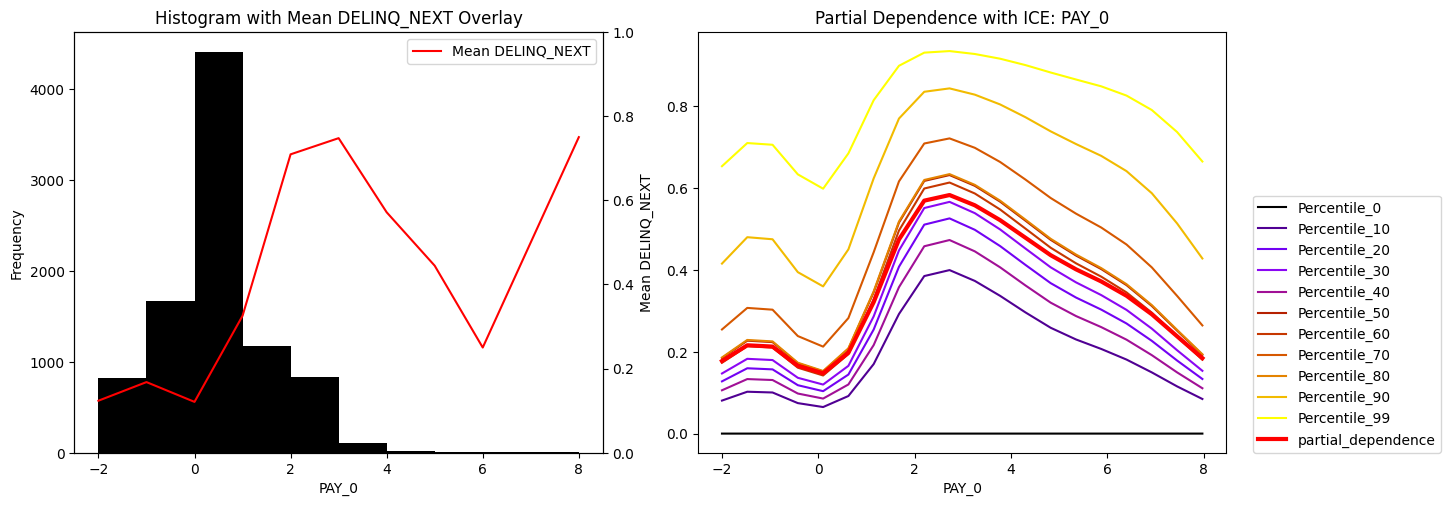

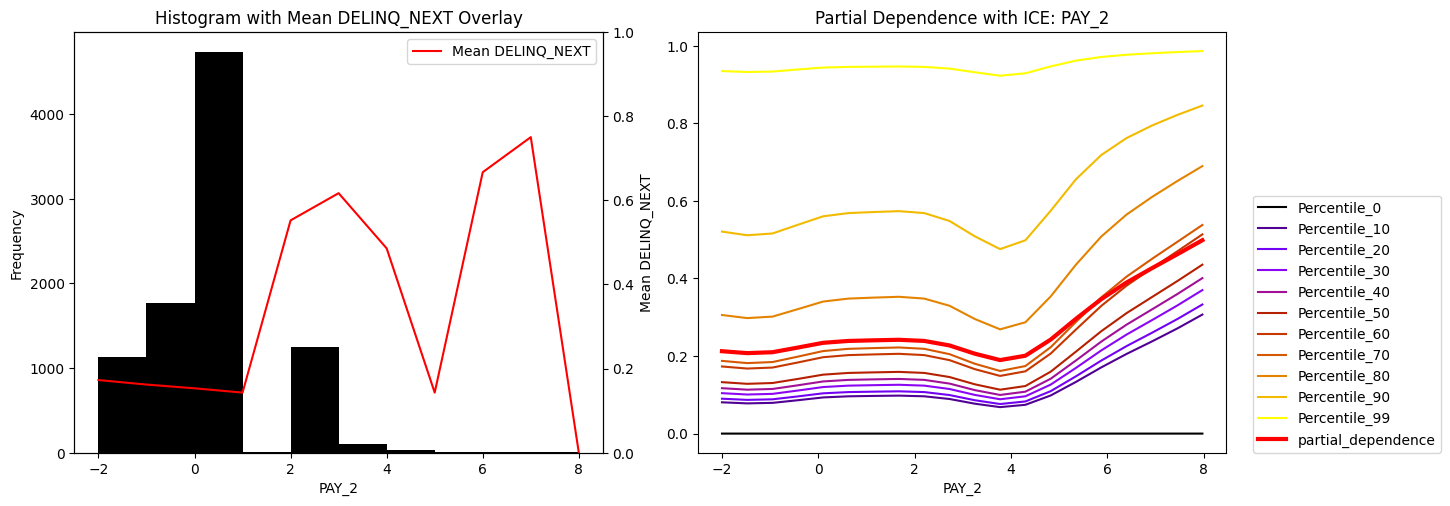

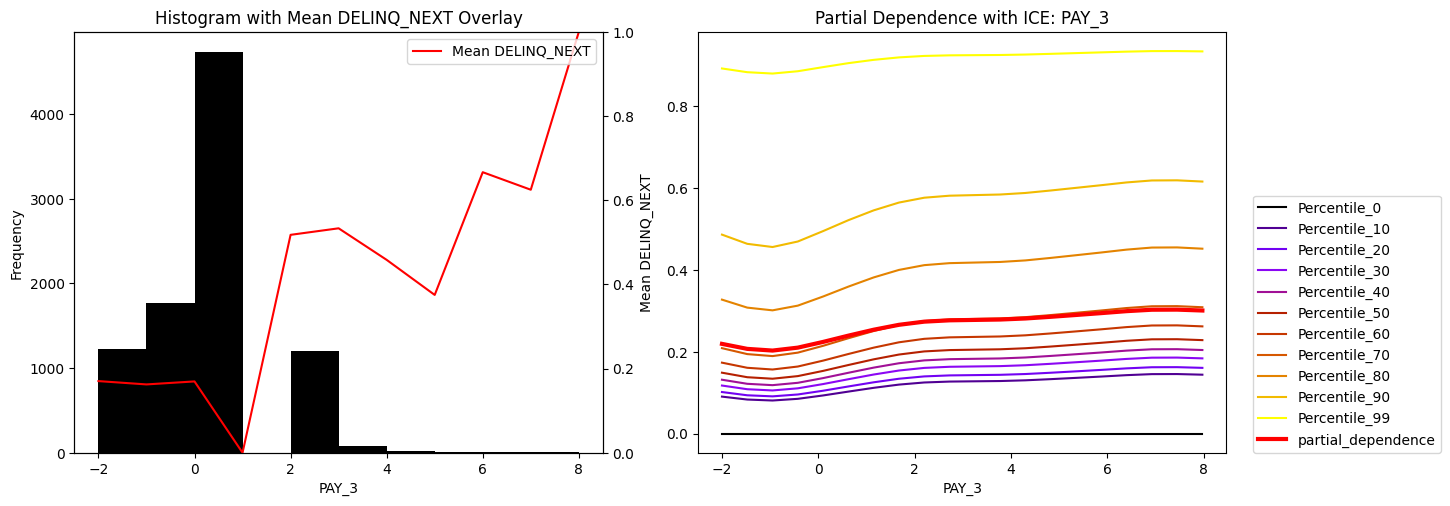

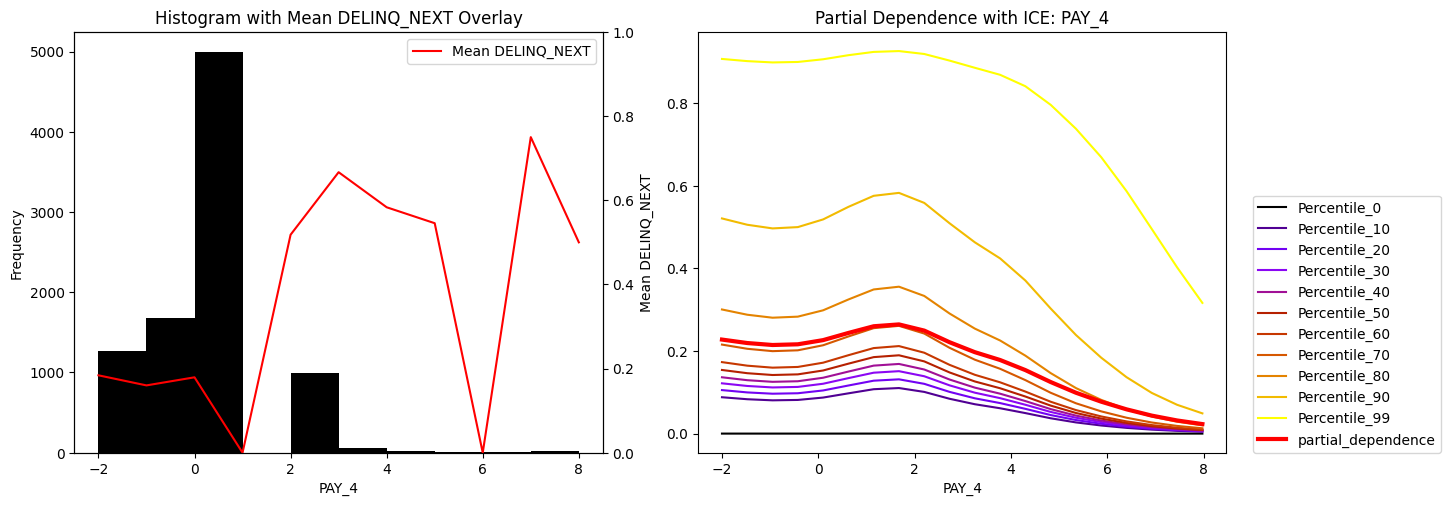

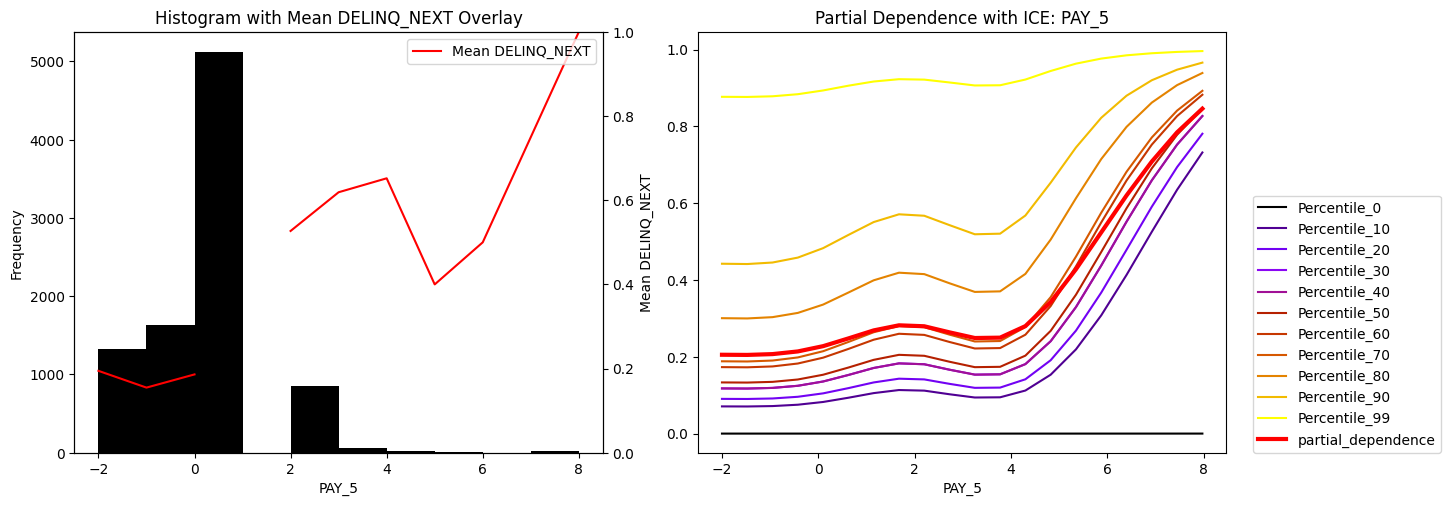

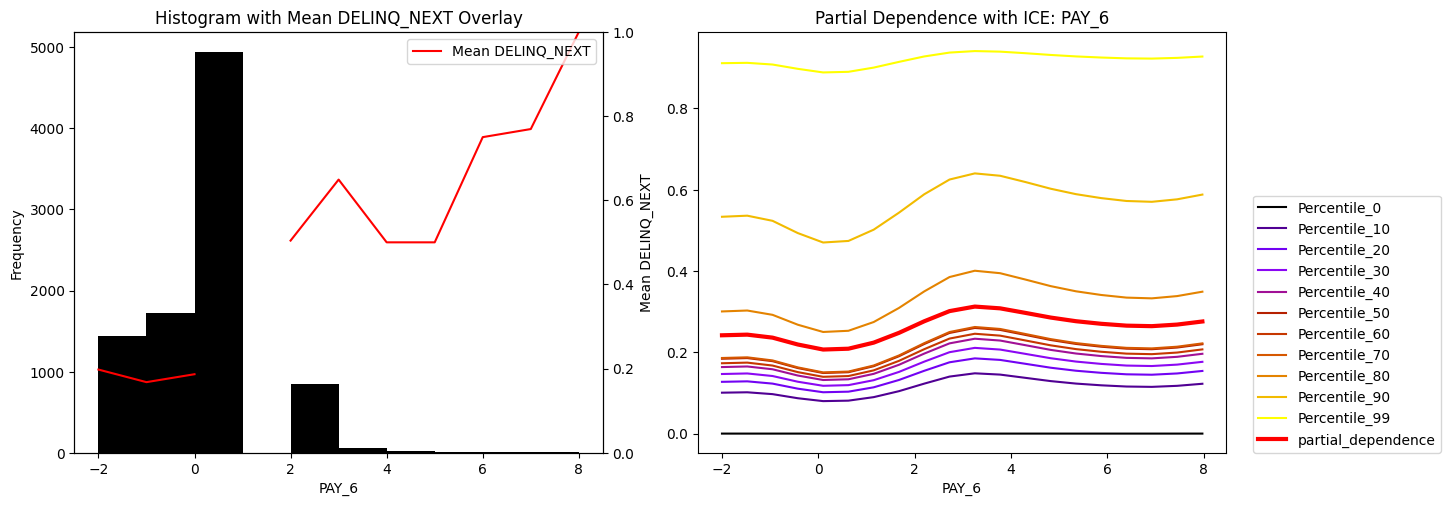

In [21]:
gam_predict = lambda data: gam.predict_proba(data[features])

for feature in glm_selected:
    explain.plot_partial_dep_ice(feature,
                                 X=valid[features],
                                 y=valid[target],
                                 predict=gam_predict)



## <a name="ebm"></a>5. GA2Ms and Explainable Boosting Machine (EBMs)



#### Train EBM with interpretml package

In [22]:
ebm = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm.fit(train[features], train[target])

ExplainableBoostingClassifier(random_state=12345)

#### Variable Importance

<Axes: ylabel='feature_names'>

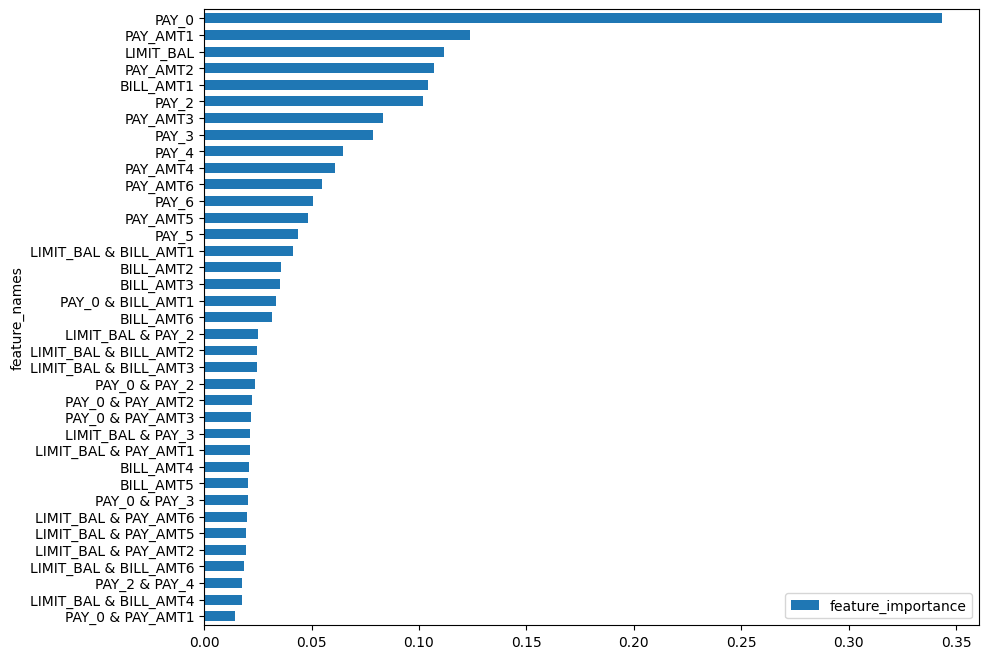

In [23]:
ebm_global = ebm.explain_global(name='EBM')
feature_names = ebm_global._internal_obj['overall']['names']
feature_importances = ebm_global._internal_obj['overall']['scores']

ebm_variable_importance = pd.DataFrame(zip(feature_names, feature_importances),
                                       columns=['feature_names','feature_importance'])

ebm_variable_importance.set_index('feature_names',inplace=True)
ebm_variable_importance.sort_values(by='feature_importance').plot(kind='barh',
                                                                       width = 0.6,
                                                                       figsize=(10,8))

#### Display interactive EBM feature plots

The live visualization shows the overall summary depicting the most important features overall. Additinally you can use the dropdown to further drill down into individual features.

In [24]:
show(ebm_global)

Output hidden; open in https://colab.research.google.com to view.

#### Computing Validation AUC

In [25]:
ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[target], name='EBM')
validation_auc = ebm_perf._internal_obj['overall']['auc']
print("Validation AUC: {0:.4f}".format(validation_auc))

Validation AUC: 0.7860


#### Plottng the Partial Dependence and ICE plots for EBM

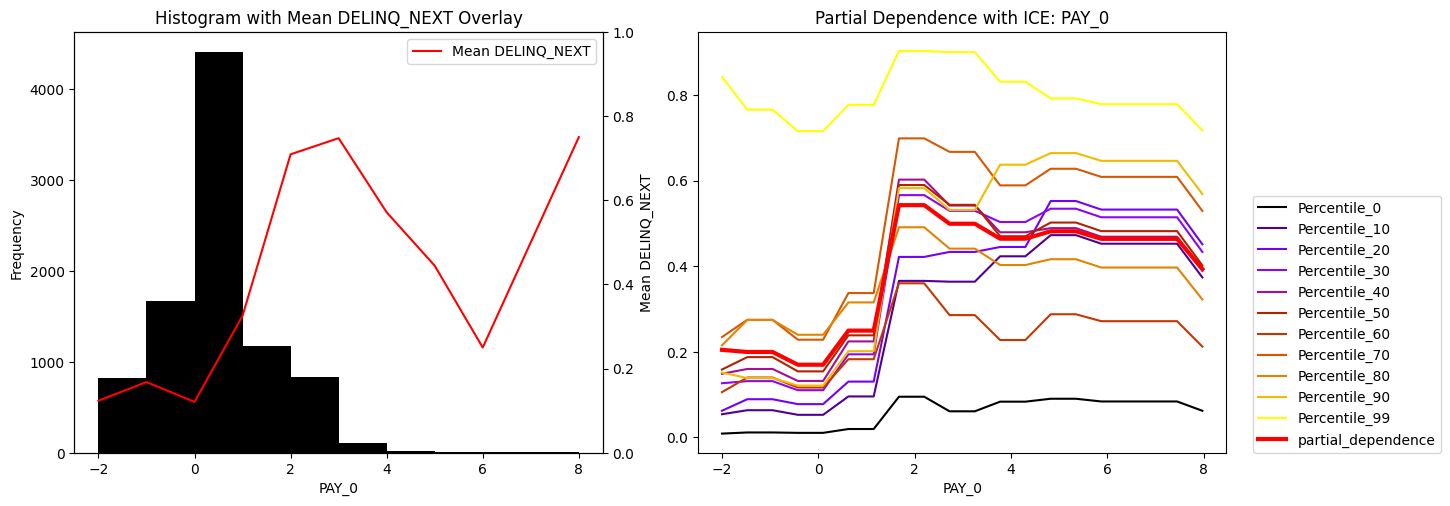

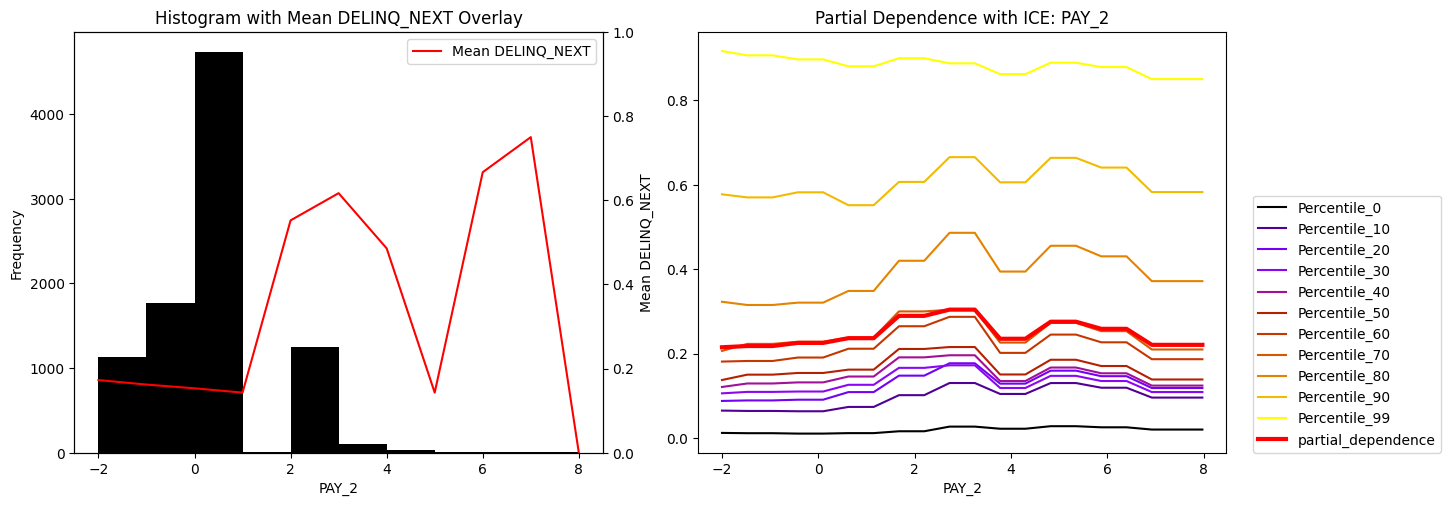

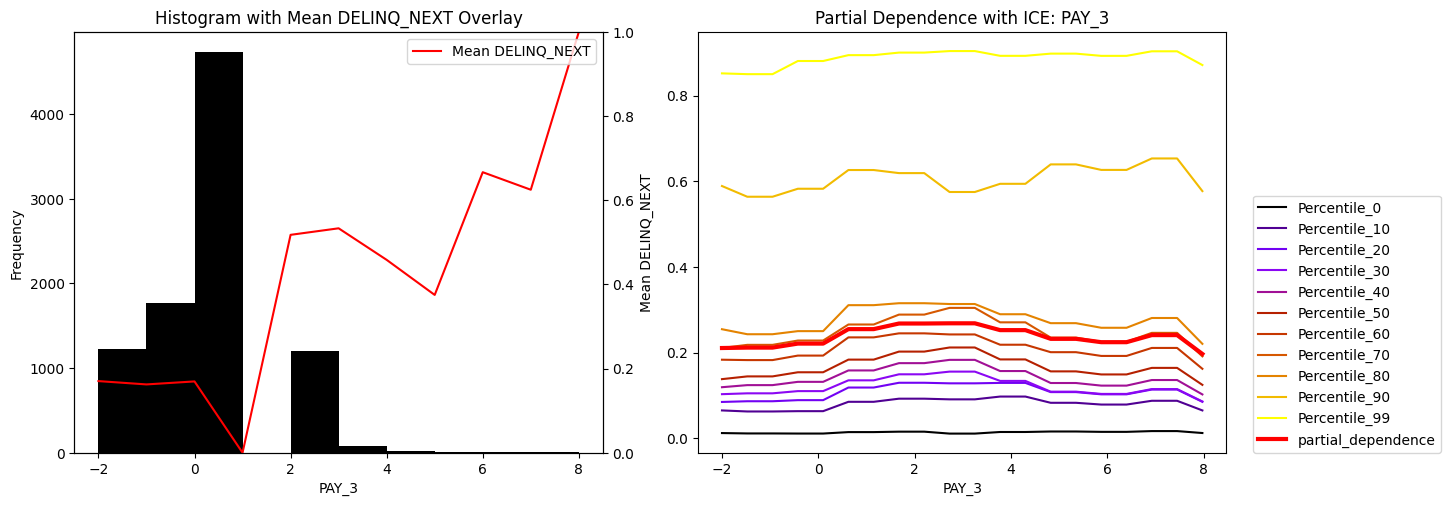

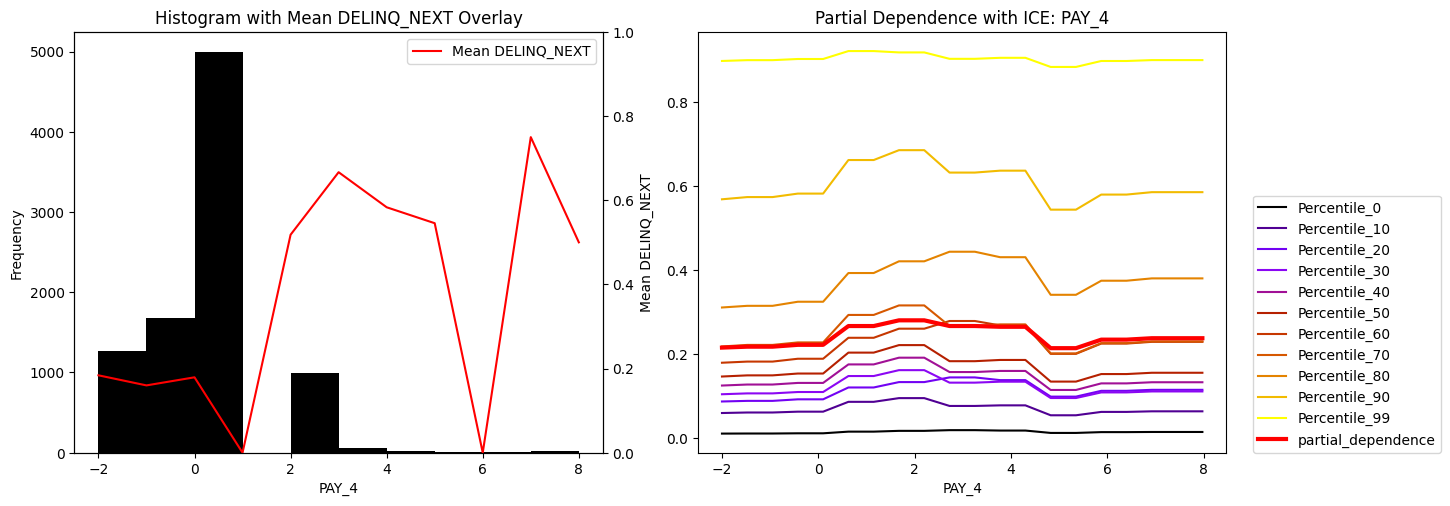

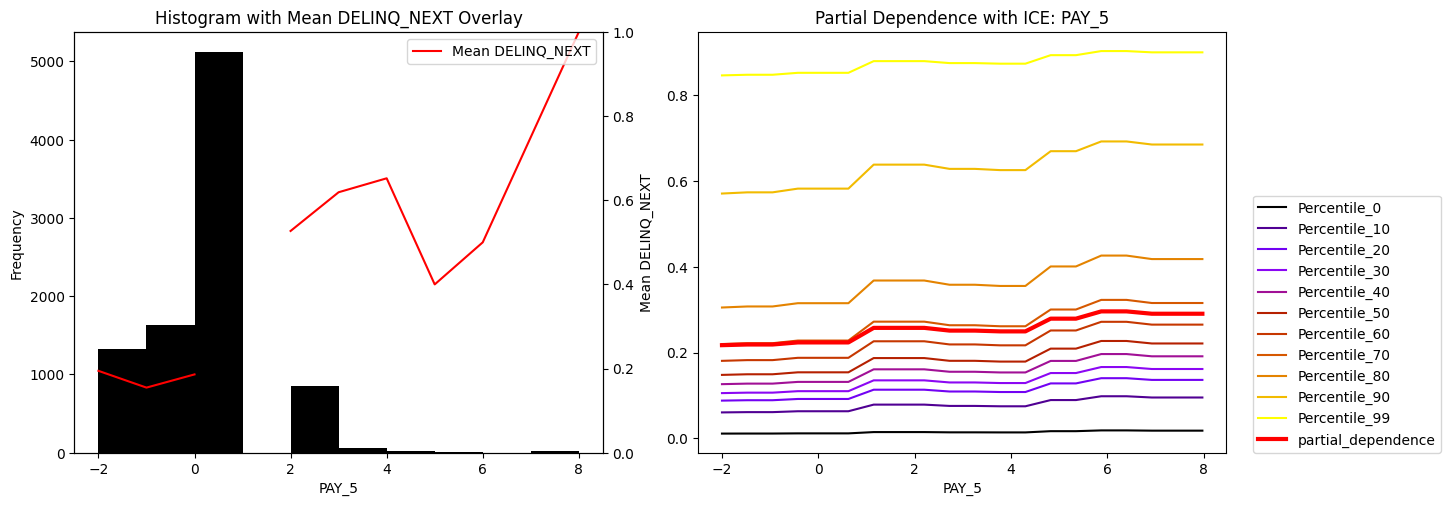

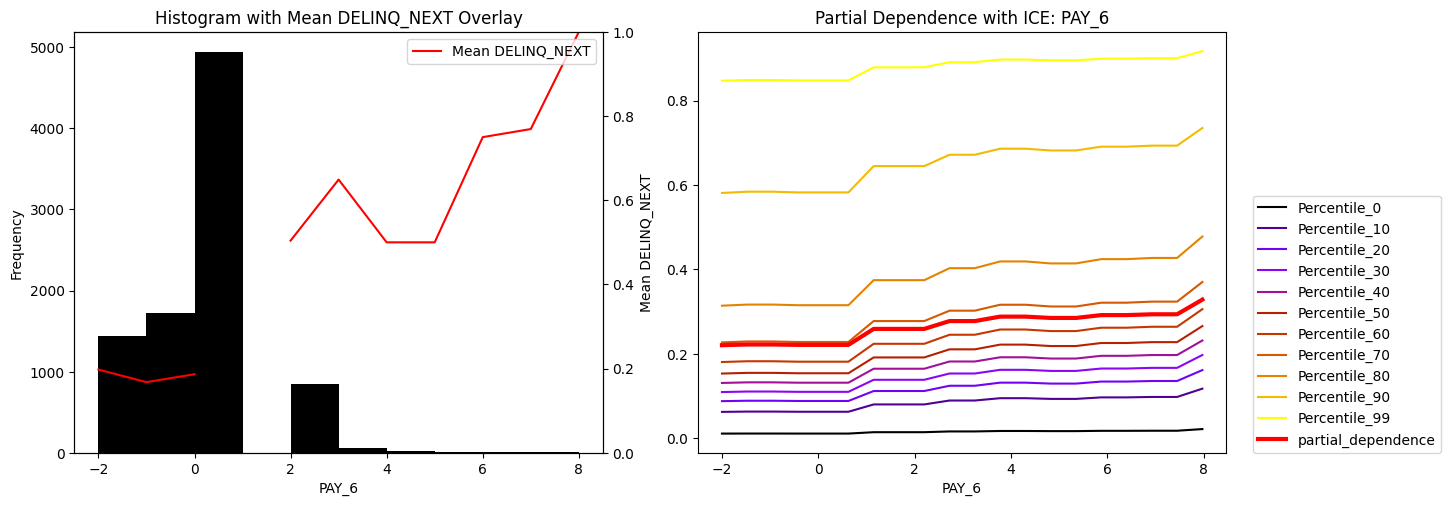

In [26]:
ebm_predict = lambda data: ebm.predict_proba(data[features])[:, 1]

for feature in glm_selected:
    explain.plot_partial_dep_ice(feature,
                                 X=valid[features],
                                 y=valid[target],
                                 predict=ebm_predict)

#### Shutdown H2O Cluster

In [27]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
H2O session _sid_bb93 closed.
